In [38]:
import pandas as pd
## for text processing
import re
import nltk

from scipy import stats

## for sentiment
# from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
## for topic modeling
import gensim
# plotting topic model
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Helper functions

In [39]:
def clean_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    """Preprocess the text. 
    Convert to lowercase, remove @user, remove punctuations and characters and then strip.
    """
    ## clean
    text = re.sub('@[^\s]+','',text)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

def get_sentence_count(text):
    """Make sure that '' or whitespace doesn't count as a sentence. """
    non_empty = [i for i in text.split('.') if i or i.isspace()]
    return len(non_empty)

def get_word_stats(df,colname:str = 'Text'):
    """Get the summary stats for word count, charater count, sentence count, avg length."""
    df['word_count'] = df[colname].apply(lambda x: len(str(x).split(" ")))
    df['char_count'] = df[colname].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

    df['sentence_count'] = df[colname].apply(lambda x: get_sentence_count(x))
    df['avg_word_length'] = df['char_count'] / df['word_count']
    df['avg_sentence_length'] = df['word_count'] / df['sentence_count']
    return df

def plot_distribution(x,category,width:int = 10, height:int = 4):
    """Plot the distribution by category."""
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (width,height))
    fig.suptitle(x, fontsize=12)
    for i in df2[category].unique():
        sns.distplot(df2[df2[category]==i][x], hist=True, kde=False, 
                    bins=10, hist_kws={"alpha":0.8}, 
                    axlabel="histogram", ax=ax[0])
        sns.distplot(df2[df2[category]==i][x], hist=False, kde=True, 
                    kde_kws={"shade":True}, axlabel="density",   
                    ax=ax[1])
    ax[0].grid(True)
    ax[0].legend(df2[category].unique())
    ax[1].grid(True)
    return fig,ax


### 1. Data profiling and preprocessing

In [50]:
df = pd.read_excel("2016 Election Random Sample.xlsx")
print(df.shape)
print(df.dtypes)
df.head(3)

(82999, 7)
Keyword       object
Handle        object
TimeStamp     object
TweetID      float64
Text          object
Followers      int64
WC             int64
dtype: object


,Keyword,Handle,TimeStamp,TweetID,Text,Followers,WC
0,Clinton,CrabbyAbbey1,Fri Oct 07 00:00:06 +0000 2016,7.841815e+17,@SarahKSilverman If you have to lie to win you...,1,16
1,Clinton,Marianne_Summer,Fri Oct 07 00:00:26 +0000 2016,7.841816e+17,Here's how much Hillary Clinton paid in taxes ...,2,11
2,Trump,SAcurrent,Fri Oct 07 00:00:32 +0000 2016,7.841816e+17,Protesters at Trump's SA Fundraiser Were Passi...,78082,11


In [51]:
df.isnull().sum()

Keyword      0
Handle       0
TimeStamp    0
TweetID      0
Text         0
Followers    0
WC           0
dtype: int64

In [52]:
# remove duplicated records
df.drop_duplicates(subset = ['Handle','TimeStamp','Text'],inplace=True)
df.reset_index(inplace=True,drop=True)

df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
# so apparently object type is not equivalent to string type
# need to explicitly transform it to str type
df['Handle'] = df['Handle'].astype(str)

print(df.shape)
print(df['TimeStamp'].min(), df['TimeStamp'].max())
df.tail(3)

(82645, 7)
2016-10-05 20:07:31+00:00 2016-10-12 23:25:22+00:00


,Keyword,Handle,TimeStamp,TweetID,Text,Followers,WC
82642,Election-General,KalonJelen,2016-10-12 23:25:17+00:00,7.863470e+17,Yeah. No one's surprised. At this point it's j...,91,24
82643,Clinton,By_SJD,2016-10-12 23:25:18+00:00,7.863470e+17,They do know that #repealthe19th just makes me...,842,27
82644,Clinton,Barbara101123,2016-10-12 23:25:22+00:00,7.863471e+17,Remember Hillary and her campaign are in Cahoo...,5,15


In [53]:
df.nunique()

Keyword          4
Handle       62012
TimeStamp    75142
TweetID      82645
Text         77628
Followers    12075
WC              26
dtype: int64

In [54]:
count_by_user = df.groupby('Handle')['TweetID'].count().reset_index()
count_by_user.sort_values(by='TweetID',ascending=False).head()

,Handle,TweetID
12796,HydroElections,118
38476,corrigan_david,82
38412,constantino_sam,61
34261,amrightnow,48
20066,MikePence20,45


In [55]:
df['Followers'].describe()

count    8.264500e+04
mean     1.148566e+04
std      3.205272e+05
min      0.000000e+00
25%      9.200000e+01
50%      4.330000e+02
75%      1.722000e+03
max      3.082208e+07
Name: Followers, dtype: float64

In [56]:
df.groupby('Keyword')['TweetID'].count()

Keyword
Both                 7051
Clinton             18999
Election-General    14734
Trump               41861
Name: TweetID, dtype: int64

In [57]:
lst_stopwords = nltk.corpus.stopwords.words("english")
# adding word 'url' to stop words
lst_stopwords.append('url')

# clean the text
df['Text_Clean'] = df['Text'].apply(lambda x: clean_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords = lst_stopwords)) 
df.head(3)

,Keyword,Handle,TimeStamp,TweetID,Text,Followers,WC,Text_Clean
0,Clinton,CrabbyAbbey1,2016-10-07 00:00:06+00:00,7.841815e+17,@SarahKSilverman If you have to lie to win you...,1,16,lie win work clinton that pretti deplor
1,Clinton,Marianne_Summer,2016-10-07 00:00:26+00:00,7.841816e+17,Here's how much Hillary Clinton paid in taxes ...,2,11,here much hillari clinton paid tax last year
2,Trump,SAcurrent,2016-10-07 00:00:32+00:00,7.841816e+17,Protesters at Trump's SA Fundraiser Were Passi...,78082,11,protest trump sa fundrais passion peac


In [59]:
df2 = get_word_stats(df,colname='Text')
df2.head(3)

,Keyword,Handle,TimeStamp,TweetID,Text,Followers,WC,Text_Clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,Clinton,CrabbyAbbey1,2016-10-07 00:00:06+00:00,7.841815e+17,@SarahKSilverman If you have to lie to win you...,1,16,lie win work clinton that pretti deplor,16,82,2,5.125000,8.0
1,Clinton,Marianne_Summer,2016-10-07 00:00:26+00:00,7.841816e+17,Here's how much Hillary Clinton paid in taxes ...,2,11,here much hillari clinton paid tax last year,11,49,1,4.454545,11.0
2,Trump,SAcurrent,2016-10-07 00:00:32+00:00,7.841816e+17,Protesters at Trump's SA Fundraiser Were Passi...,78082,11,protest trump sa fundrais passion peac,11,62,1,5.636364,11.0


In [60]:
df2.describe()

,TweetID,Followers,WC,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
count,8.264500e+04,8.264500e+04,82645.000000,82645.000000,82645.000000,82645.000000,82645.000000,82645.000000
mean,7.851709e+17,1.148566e+04,17.109226,17.873035,86.375328,1.619396,4.934283,13.150955
std,2.802582e+15,3.205272e+05,4.489523,4.888685,20.860979,0.860504,0.890255,5.740554
min,2.000000e+01,0.000000e+00,10.000000,8.000000,25.000000,1.000000,0.597701,1.000000
25%,7.848116e+17,9.200000e+01,13.000000,14.000000,70.000000,1.000000,4.333333,9.000000
50%,7.852274e+17,4.330000e+02,17.000000,18.000000,90.000000,1.000000,4.833333,12.000000
75%,7.856449e+17,1.722000e+03,20.000000,21.000000,101.000000,2.000000,5.409091,17.000000
max,7.863471e+17,3.082208e+07,46.000000,87.000000,134.000000,22.000000,13.500000,87.000000


#### Plot word count stats by keyword

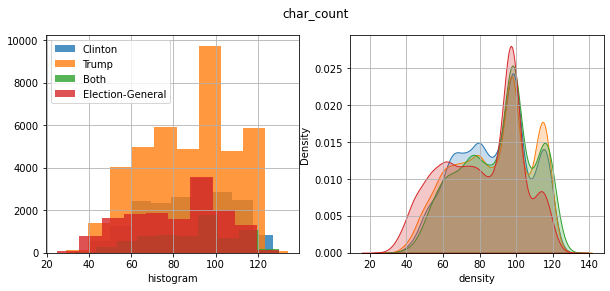

In [61]:
x, y = "char_count", "Keyword"
fig,ax = plot_distribution(x,y)
plt.show()

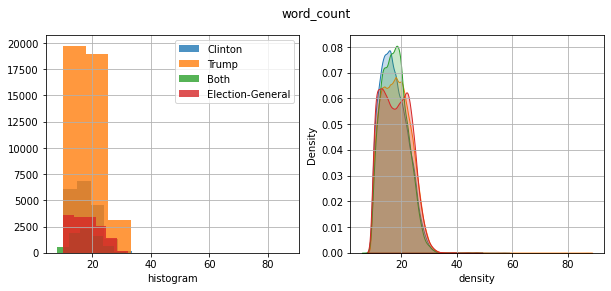

In [62]:
x, y = "word_count", "Keyword"
fig,ax = plot_distribution(x,y)
plt.show()

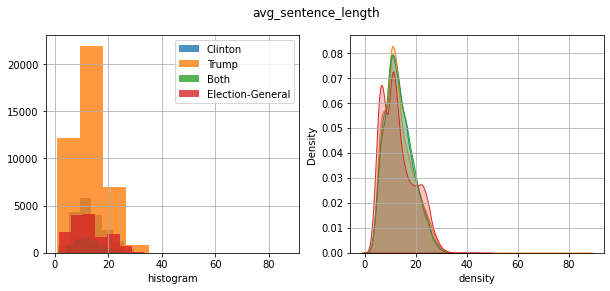

In [63]:
x, y = "avg_sentence_length", "Keyword"
fig,ax = plot_distribution(x,y)
plt.show()

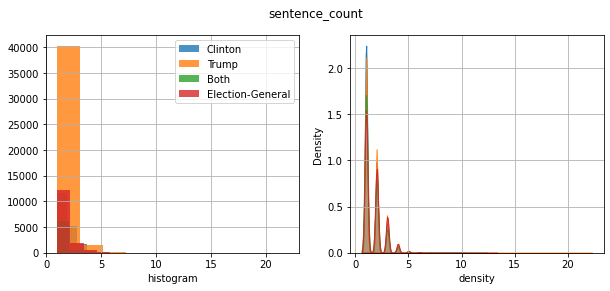

In [64]:
x, y = "sentence_count", "Keyword"
fig,ax = plot_distribution(x,y)
plt.show()

### 2. Sentiment Analysis

#### Using Vader instead of TextBlob

In [65]:
analyzer = SentimentIntensityAnalyzer()

df2["sentiment_vader"] = df2['Text_Clean'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df2.head(3)

,Keyword,Handle,TimeStamp,TweetID,Text,Followers,WC,Text_Clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,sentiment_vader
0,Clinton,CrabbyAbbey1,2016-10-07 00:00:06+00:00,7.841815e+17,@SarahKSilverman If you have to lie to win you...,1,16,lie win work clinton that pretti deplor,16,82,2,5.125000,8.0,0.5859
1,Clinton,Marianne_Summer,2016-10-07 00:00:26+00:00,7.841816e+17,Here's how much Hillary Clinton paid in taxes ...,2,11,here much hillari clinton paid tax last year,11,49,1,4.454545,11.0,0.0000
2,Trump,SAcurrent,2016-10-07 00:00:32+00:00,7.841816e+17,Protesters at Trump's SA Fundraiser Were Passi...,78082,11,protest trump sa fundrais passion peac,11,62,1,5.636364,11.0,0.2500


In [66]:
sentiment_col = "sentiment_vader"

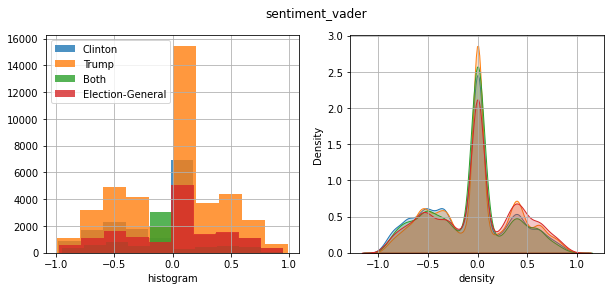

In [67]:
x, y = sentiment_col, "Keyword"
fig,ax = plot_distribution(x,y)
plt.show()

In [68]:
df2.groupby('Keyword')[sentiment_col].describe()

,count,mean,std,min,25%,50%,75%,max
Keyword,,,,,,,,
Both,7051.0,-0.072934,0.389990,-0.9501,-0.3622,0.0,0.0000,0.9509
Clinton,18999.0,-0.085216,0.410470,-0.9779,-0.4019,0.0,0.0772,0.9451
Election-General,14734.0,-0.019972,0.424616,-0.9764,-0.3400,0.0,0.3182,0.9517
Trump,41861.0,-0.034949,0.405138,-0.9887,-0.3400,0.0,0.2263,0.9887


In [69]:
# t test on whether there's difference on the sentiment of Trump VS Clinton
print(stats.ttest_ind(df2.loc[df2['Keyword']=='Trump',sentiment_col], df2.loc[df2['Keyword']=='Clinton',sentiment_col]))
# print(stats.ttest_ind(df2.loc[df2['Keyword']=='Trump',sentiment_col], df2.loc[df2['Keyword']=='Clinton',sentiment_col],equal_var=False))

Ttest_indResult(statistic=14.12535432082424, pvalue=3.1255585585655863e-45)


In [70]:
df2[['Followers',sentiment_col]].corr()

,Followers,sentiment_vader
Followers,1.000000,-0.000941
sentiment_vader,-0.000941,1.000000


In [71]:
sentiment_col_abs = f'{sentiment_col}_abs'
df2[sentiment_col_abs] = abs(df2[sentiment_col])
df2[['Followers',sentiment_col_abs]].corr()

,Followers,sentiment_vader_abs
Followers,1.00000,-0.01044
sentiment_vader_abs,-0.01044,1.00000


In [72]:
df2.groupby('Keyword')['Followers'].describe()

,count,mean,std,min,25%,50%,75%,max
Keyword,,,,,,,,
Both,7051.0,20940.096015,526503.835091,0.0,77.5,422.0,1806.0,30791230.0
Clinton,18999.0,9412.721564,328857.433726,0.0,96.0,500.0,1964.0,30730837.0
Election-General,14734.0,3756.097462,52380.240016,0.0,107.0,404.5,1427.0,5186908.0
Trump,41861.0,13554.598600,325665.019208,0.0,89.0,422.0,1703.0,30822080.0


In [73]:
# try to split the users posts by #followers they have
num_followers_list = df2.drop_duplicates(subset = 'Handle')['Followers']
q1, q3 = num_followers_list.quantile([.25,.75])
lower_boundary = q1-1.5*(q3-q1)
higher_boundary = q3+1.5*(q3-q1)
print(lower_boundary,higher_boundary)

-1852.0 3292.0


In [74]:
df2['group'] = '<1k followers'
df2.loc[df2['Followers']>=1e3,'group'] = '1k~100k followers'
df2.loc[df2['Followers']>=1e5,'group'] = '>=100k followers'

In [75]:
df2.groupby(['group'])[sentiment_col].describe().sort_values(by='count',ascending=False)

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
<1k followers,54028.0,-0.041714,0.414661,-0.9833,-0.3612,0.0,0.2500,0.9887
1k~100k followers,27925.0,-0.057420,0.399260,-0.9887,-0.3412,0.0,0.1280,0.9584
>=100k followers,692.0,-0.048170,0.388196,-0.9559,-0.3400,0.0,0.0772,0.8316


In [76]:
df2.groupby(['group'])[sentiment_col_abs].describe().sort_values(by='count',ascending=False)

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
<1k followers,54028.0,0.310369,0.278123,0.0,0.0,0.3182,0.5423,0.9887
1k~100k followers,27925.0,0.294249,0.275899,0.0,0.0,0.2960,0.5106,0.9887
>=100k followers,692.0,0.277983,0.275016,0.0,0.0,0.2732,0.5106,0.9559


In [77]:
df2.groupby(['Keyword','group'])[sentiment_col].describe().reset_index().sort_values(by=['Keyword','count'],ascending=[True,False])

,Keyword,group,count,mean,std,min,25%,50%,75%,max
1,Both,<1k followers,4570.0,-0.072253,0.393859,-0.9501,-0.3818,0.0,0.00000,0.9509
0,Both,1k~100k followers,2378.0,-0.073027,0.381879,-0.9493,-0.3400,0.0,0.00000,0.8934
2,Both,>=100k followers,103.0,-0.101007,0.405323,-0.7579,-0.4853,0.0,0.00000,0.7184
4,Clinton,<1k followers,11843.0,-0.078872,0.417190,-0.9779,-0.4019,0.0,0.10270,0.9451
3,Clinton,1k~100k followers,7023.0,-0.097213,0.398715,-0.9698,-0.4019,0.0,0.02580,0.9217
5,Clinton,>=100k followers,133.0,-0.016613,0.402554,-0.9559,-0.1280,0.0,0.25000,0.8273
7,Election-General,<1k followers,10085.0,-0.018644,0.428304,-0.9698,-0.3400,0.0,0.31820,0.9331
6,Election-General,1k~100k followers,4586.0,-0.023855,0.416556,-0.9764,-0.3182,0.0,0.29600,0.9517
8,Election-General,>=100k followers,63.0,0.050102,0.411818,-0.7717,-0.0286,0.0,0.39185,0.7650
10,Trump,<1k followers,27530.0,-0.029111,0.410528,-0.9833,-0.3400,0.0,0.27880,0.9887


In [78]:
df2.groupby(['Keyword','group'])[sentiment_col_abs].describe().reset_index().sort_values(by=['Keyword','count'],ascending=[True,False])

,Keyword,group,count,mean,std,min,25%,50%,75%,max
1,Both,<1k followers,4570.0,0.283229,0.283038,0.0,0.0,0.26905,0.52670,0.9509
0,Both,1k~100k followers,2378.0,0.267824,0.281793,0.0,0.0,0.20230,0.49390,0.9493
2,Both,>=100k followers,103.0,0.316537,0.270944,0.0,0.0,0.31820,0.58590,0.7579
4,Clinton,<1k followers,11843.0,0.315478,0.284137,0.0,0.0,0.31820,0.54230,0.9779
3,Clinton,1k~100k followers,7023.0,0.299100,0.280983,0.0,0.0,0.29600,0.52545,0.9698
5,Clinton,>=100k followers,133.0,0.276256,0.292288,0.0,0.0,0.20230,0.52670,0.9559
7,Election-General,<1k followers,10085.0,0.325180,0.279355,0.0,0.0,0.33610,0.54230,0.9698
6,Election-General,1k~100k followers,4586.0,0.311407,0.277655,0.0,0.0,0.31820,0.53995,0.9764
8,Election-General,>=100k followers,63.0,0.295873,0.288430,0.0,0.0,0.29600,0.56465,0.7717
10,Trump,<1k followers,27530.0,0.307251,0.273813,0.0,0.0,0.31820,0.52670,0.9887


<AxesSubplot:xlabel='group', ylabel='sentiment_vader'>

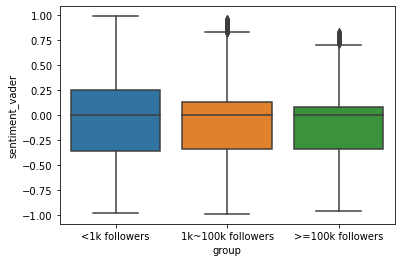

In [79]:
sns.boxplot(x = 'group',y = sentiment_col,data = df2)

In [80]:
# t test on whether there's difference on the number of followers of blogs talking about Trump VS Clinton
print(stats.ttest_ind(df2.loc[df2['Keyword']=='Trump','Followers'], df2.loc[df2['Keyword']=='Clinton','Followers']))
# print(stats.ttest_ind(df2.loc[df2['Keyword']=='Trump','Followers'], df2.loc[df2['Keyword']=='Clinton','Followers'],equal_var=False))

Ttest_indResult(statistic=1.449435417842461, pvalue=0.14722117652025218)


### 4. Topic models

In [81]:
pos = df2[df2[sentiment_col]>=0.05]
neg = df2[df2[sentiment_col]<=-0.05]

In [82]:
num_topics = 3

for cat in ("Clinton","Trump"):
    for name,subdf in zip(("pos","neg"),(pos,neg)):
        processed_text = [nltk.word_tokenize(i) for i in subdf.loc[subdf['Keyword']==cat,'Text_Clean']]

        #create a dictionary of the words
        dictionary = gensim.corpora.Dictionary(processed_text)
        #create a TDM
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in processed_text]
        # build lda model
        lda_model_clinton_pos = gensim.models.ldamodel.LdaModel(corpus = doc_term_matrix, #TDM
                                                    id2word = dictionary, #Dictionary
                                                    num_topics = num_topics, 
                                                    random_state = 100,
                                                    update_every = 1,
                                                    chunksize = 100,
                                                    passes = 10,
                                                    alpha = 'auto',
                                                    per_word_topics = True)
        # create topic model viz
        vis = gensimvis.prepare(lda_model_clinton_pos, doc_term_matrix, dictionary, n_jobs = 1)
        pyLDAvis.save_html(vis, f'./output/LDA_Visualization_{num_topics}topics_{cat}_{name}.html') ##saves the file
        # vis

# include plots
knitr::include_graphics('filename.png')